In [1]:
from scipy.optimize import minimize
from numpy.random import rand
import numpy as np 
from matplotlib import pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.stats
from scipy.linalg import sqrtm
from scipy.integrate import quad
from scipy.stats import norm
from scipy.stats import bernoulli
from shapely.geometry import LineString
from scipy import optimize
import math
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Provide your file path for test1.txt
filename = '/Users/dronakhurana/Desktop/ellipsoid_exps/output/test1.txt' 
#Please provide file paths for test1.xlsx, test2.xlsx and test3.xlsx
file1 = '/Users/dronakhurana/Desktop/ellipsoid_exps/upperbd/test1.xlsx'
file2 = '/Users/dronakhurana/Desktop/ellipsoid_exps/upperbd/test2.xlsx'
file3 = '/Users/dronakhurana/Desktop/ellipsoid_exps/upperbd/test3.xlsx'

In [3]:
############################# FUNCTIONS ############################# 

In [4]:
#Helper functions

#Check if matrix is positive definite 
def is_pos_def(M):
    return np.all(np.linalg.eigvals(M) > 0)

#Get sqrt of a matrix via diagonalization
def diag_sqrt(A):
    e_vals, E_vectors = np.linalg.eigh(A) #eigenvalues and vectors
    #diagonalize
    A_sqrt = E_vectors @ np.diag(np.sqrt(e_vals)) @ E_vectors.transpose()
    return(A_sqrt)

#Given a centre, c, and a matrix, A, plot the corresponding ellipsoid
def plot_ellipsoid(c, A, col, l=None):
    ax.set_aspect('equal')
    eigenvalues, eigenvectors = np.linalg.eig(A)
    theta = np.linspace(0, 2*np.pi, 1000)
    ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)]
    plt.plot(c[0], c[1], marker = '*',color = col)
    plt.plot(ellipsis[0,:] + c[0], ellipsis[1,:] + c[1], color = col, linestyle = l)

In [5]:
#Functions for the X~Gaussian, y|X ~ sigmoid probability models

#Sigmoid
def sigmoid(w, b, x):
    #w scalar, x vector
    return 1 / (1 + np.exp(-w*x - b))

#Sigmoid
def sigmoid_vec(w, x): 
    return 1 / (1 + np.exp(-w.flatten().dot(x.flatten())))

#For calculating I_'s
def intergrand_(x, mu, sigma):
    return(norm.pdf(x, mu, sigma))

#For calculating true class probabilities
def intergrand_y(x, w, b, mu, sigma): 
    w = np.array([w, b])
    x = np.array([x, 1])
    return (sigmoid_vec(w, x)*(norm.pdf(x[0], mu, sigma)))

#For calculating C01
def intergrand_C01(x, w, b, mu, sigma): 
    w = np.array([w, b])
    x = np.array([x, 1])
    return ((1.0 - sigmoid_vec(w, x))*(norm.pdf(x[0], mu, sigma)))

#For calculating C10
def intergrand_C10(x, w, b, mu, sigma): 
    w = np.array([w, b])
    x = np.array([x, 1])
    return ((sigmoid_vec(w, x))*(norm.pdf(x[0], mu, sigma)))

#Expectation of L1 norm difference b/w eta and eta_hat
def integrand_rho(x, w, w_, b, b_, mu, sigma):
    w = np.array([w,b])
    w_ = np.array([w_,b_])
    x = np.array([x, 1])
    return np.abs(sigmoid_vec(w,x) - sigmoid_vec(w_,x))*(norm.pdf(x[0], mu, sigma))

#Obtain approx error analytically - this is not really used anywhere in the script
def get_approx_error(hyp, N, d, L, delta, w, w_hat, b, b_hat, mu, sigma):
    E = quad(integrand_rho, -np.inf, np.inf, args=(w, w_hat, b, b_hat, mu, sigma))[0]
    rho = 2*(2*L)*(np.sqrt(d))*E
    rho_ = hyp*np.sqrt((d*np.log(d) + np.log(N*d) + np.log(1.0/delta))/N)
    tau = 4*L*(rho+rho_)
    return(tau)

#Generate validation data set
def get_val_data(val_size, mu, sigma, w, b): 
    
    #Feature vector
    X = np.random.normal(mu, sigma, val_size)
    #Get vector of predicted probabilities
    probs = sigmoid(w, b, X) #b= 0.0 
    #Sample labels
    Y = np.random.binomial(n = 1, p = probs)
    X = X.reshape(-1,1)
    n = 2
    d = n*n #dimension of confusion vector
    return(X, Y)

#Generate training/ test data
def gen_data(N, mu, sigma, w, b):
    
    #Feature vector
    X = np.random.normal(mu, sigma, N)
    #Get vector of predicted probabilities
    probs = sigmoid(w, b, X) #b= 0.0 
    #Sample labels
    Y = np.random.binomial(n = 1, p = probs)
    X = X.reshape(-1,1)
    n = 2
    d = n*n #dimension of confusion vector

    #Split train-test
    test_split = 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_split, random_state=0)
    return(X_train, X_test, y_train, y_test)

#Fit model
def fit_model(model, X_train, y_train, X_val, w, b): 
    
    #Training
    model.fit(X_train, y_train)
    #Predictions
    Y_pred_val = model.predict(X_val)
    Y_pred_probs_val = model.predict_proba(X_val)
    #Coefficient estimators 
    w_hat = model.coef_
    b_hat = model.intercept_
    param_est = (w_hat, b_hat)
    #Est error (roughly)
    param_err = np.abs(w_hat-w) + np.abs(b_hat - b)
    return(Y_pred_probs_val, param_est, param_err)

#Get true class probabilities, assuming a sigmoid model
def get_class_probs(w, b, mu, sigma): 
    y_1 = quad(intergrand_y, -np.inf, np.inf, args=(w, b, mu, sigma))[0]
    y_0 = 1.0 - y_1
    return(y_0, y_1)

#Get confusion matrix for bayes optimal classifier corresponding to psi = C01 + C10 (for now)
def get_conf_matrix(w, b, mu, sigma): 
    y_0, y_1 = get_class_probs(w, b, mu, sigma)
    int_lim = -b/w
    if(w>0): 
        C01 = quad(intergrand_C01, int_lim, np.inf, args = (w, b, mu, sigma))[0]
        C10 = quad(intergrand_C10, -np.inf, int_lim, args = (w, b, mu, sigma))[0]
    else: 
        C01 = quad(intergrand_C01, -np.inf, int_lim, args = (w, b, mu, sigma))[0]
        C10 = quad(intergrand_C10, int_lim, np.inf, args = (w, b, mu, sigma))[0]
    C00 = y_0 - C01
    C11 = y_1 - C10
    conf = np.array([[C00, C01], [C10, C11]])
    return(conf)

#Get space of achievable confusion matrices for continuous eta 
def get_space_conf_matrices(w, b, mu, sigma, delta, y_0, y_1): 
    """
    delta: discretization parameter, smaller the better
    """
    line = np.arange(0, 1 + delta, delta)
    confs = np.zeros((2*len(line), 4))

    for i, c in enumerate(line): 
        if(c==0): 
            confs[0, :] = 0.0, y_0, 0.0, y_1
            confs[len(line), :] = y_0, 0, y_1, 0.0
        elif(c==1): 
            confs[len(line)-1, :] = y_0, 0, y_1, 0.0
            confs[-1, :] = 0.0, y_0, 0.0, y_1
        else: 
            if(w==0): 
                if (np.log((1.0/c) - 1) + b >= 0.0): 
                    confs[i, :] = 0.0, y_0, 0.0, y_1
                    confs[len(line)+i, :] = y_0, 0, y_1, 0.0
                else: 
                    confs[i, :] = y_0, 0, y_1, 0.0
                    confs[len(line)+i, :] = 0.0, y_0, 0.0, y_1
            else: 
                int_lim = (np.log((1.0/c)-1) + b)/(-1.0*w)
                if(w>0): 
                    C01 = quad(intergrand_C01, int_lim, np.inf, args = (w, b, mu, sigma))[0]
                    C10 = quad(intergrand_C10, -np.inf, int_lim, args = (w, b, mu, sigma))[0]
                    C00 = y_0 - C01
                    C11 = y_1 - C10
                    confs[i, :] = C00, C01, C10, C11
                
                    C01 = quad(intergrand_C01, -np.inf, int_lim, args = (w, b, mu, sigma))[0]
                    C10 = quad(intergrand_C10, int_lim, np.inf, args = (w, b, mu, sigma))[0]
                    C00 = y_0 - C01
                    C11 = y_1 - C10
                    confs[len(line)+i, :] = C00, C01, C10, C11
            
                else: 
                    C01 = quad(intergrand_C01, -np.inf, int_lim, args = (w, b, mu, sigma))[0]
                    C10 = quad(intergrand_C10,  int_lim, np.inf, args = (w, b, mu, sigma))[0]
                    C00 = y_0 - C01
                    C11 = y_1 - C10
                    confs[i, :] = C00, C01, C10, C11
                
                    C01 = quad(intergrand_C01, int_lim, np.inf, args = (w, b, mu, sigma))[0]
                    C10 = quad(intergrand_C10,  -np.inf, int_lim, args = (w, b, mu, sigma))[0]
                    C00 = y_0 - C01
                    C11 = y_1 - C10
                    confs[len(line)+i, :] = C00, C01, C10, C11
                    
    return(confs)
    

#Get true confusion matrix for any classifier parameterised by w_hat, b_hat
def get_true_conf_matrix(L, delta_, x_, w, b, mu, sigma, y_0, y_1): 
    L = np.array([L[0], 0, 0, L[1]])
    el_1 = L[0] - L[1]
    el_2 = L[2] - L[3]
    if(el_1 == el_2): 
        if(el_1>0):
            cm = np.array([[0, y_0], [0, y_1]])
            return(cm)
        else: 
            cm = np.array([[y_0, 0], [y_1, 0]])
            return(cm)
    elif(el_2 > el_1): 
        c1 = (-el_1)/(el_2-el_1) - delta_
        c2 = (-el_1)/(el_2-el_1)
        if(c1<=0): 
            I1 = quad(intergrand_C01, -np.inf, x_, args = (w, b, mu, sigma))[0]
            I1_ = quad(intergrand_, -np.inf, x_, args = (mu, sigma))[0]
        elif(c1>=1): 
            I1 = 0
            I1_ = 0
        else: 
            if(w==0):
                if(np.log((1.0/c1)-1) + b > 0): 
                    I1 = quad(intergrand_C01, -np.inf, x_, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, -np.inf, x_, args = (mu, sigma))[0]
                else: 
                    I1 = 0
                    I1_ = 0
            elif(w>0):
                d1 = (-(np.log((1.0/c1)-1) + b))/(w)
                if (d1 > x_): 
                    I1 = 0
                    I1_ = 0
                else: 
                    I1 = quad(intergrand_C01, d1, x_, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, d1, x_, args = (mu, sigma))[0]
            else: 
                d1 = (-(np.log((1.0/c1)-1) + b))/(w)
                if (d1>x_): 
                    I1 = quad(intergrand_C01, -np.inf, x_, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, -np.inf, x_, args = (mu, sigma))[0]
                else: 
                    I1 = quad(intergrand_C01, -np.inf, d1, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, -np.inf, d1, args = (mu, sigma))[0]

        if(c2<=0):
            I2 = quad(intergrand_C01, x_, np.inf, args = (w, b, mu, sigma))[0]
            I2_ = quad(intergrand_, x_, np.inf, args = (mu, sigma))[0]
        elif(c2>=1):
            I2 = 0
            I2_ = 0
        else: 
            if(w==0):
                if(np.log((1.0/c2) - 1) + b > 0):
                    I2 = quad(intergrand_C01, x_, np.inf, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, x_, np.inf, args = (mu, sigma))[0]
                else: 
                    I2 = 0
                    I2_ = 0
            elif(w>0):
                d2 = (-(np.log((1.0/c2)-1) + b))/(w)
                if(d2<x_): 
                    I2 = quad(intergrand_C01, x_, np.inf, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, x_, np.inf, args = (mu, sigma))[0]
                else: 
                    I2 = quad(intergrand_C01, d2, np.inf, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, d2, np.inf, args = (mu, sigma))[0]
            else: 
                d2 = (-(np.log((1.0/c2)-1) + b))/(w)
                if(d2<x_): 
                    I2 = 0
                    I2_ = 0
                else: 
                    I2 = quad(intergrand_C01, x_, d2, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, x_, d2, args = (mu, sigma))[0]
        C01 = I1 + I2 
        C00 = y_0 - C01
    else: 
        c1 = (-el_1)/(el_2-el_1) - delta_
        c2 = (-el_1)/(el_2-el_1)
        if(c1<=0): 
            I1 = 0
            I1_ = 0
        elif(c1>=1): 
            I1 = quad(intergrand_C01, -np.inf, x_, args = (w, b, mu, sigma))[0]
            I1_ = quad(intergrand_, -np.inf, x_, args = (mu, sigma))[0]
        else: 
            if(w==0):
                if(np.log((1.0/c1)-1) + b < 0): 
                    I1 = quad(intergrand_C01, -np.inf, x_, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, -np.inf, x_, args = (mu, sigma))[0]
                else: 
                    I1 = 0
                    I1_ = 0
            elif(w>0):
                d1 = (-(np.log((1.0/c1)-1) + b))/(w)
                if (d1 < x_): 
                    I1 = quad(intergrand_C01, -np.inf, d1, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, -np.inf, d1, args = (mu, sigma))[0]
                else: 
                    I1 = quad(intergrand_C01, -np.inf, x_, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, -np.inf, x_, args = (mu, sigma))[0]
            else: 
                d1 = (-(np.log((1.0/c1)-1) + b))/(w)
                if (d1<x_): 
                    I1 = quad(intergrand_C01, d1, x_, args = (w, b, mu, sigma))[0]
                    I1_ = quad(intergrand_, d1, x_, args = (mu, sigma))[0]
                else: 
                    I1 = 0
                    I1_ = 0

        if(c2<=0):
            I2 = 0
            I2_ = 0
        elif(c2>=1):
            I2 = quad(intergrand_C01, x_, np.inf, args = (w, b, mu, sigma))[0]
            I2_ = quad(intergrand_, x_, np.inf, args = (mu, sigma))[0]
        else: 
            if(w==0):
                if(np.log((1.0/c2) - 1) + b < 0):
                    I2 = quad(intergrand_C01, x_, np.inf, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, x_, np.inf, args = (mu, sigma))[0]
                else: 
                    I2 = 0
                    I2_ = 0
            elif(w>0):
                d2 = (-(np.log((1.0/c2)-1) + b))/(w)
                if(d2>x_): 
                    I2 = quad(intergrand_C01, x_, d2, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, x_, d2, args = (mu, sigma))[0]
                else: 
                    I2 = 0
                    I2_ = 0
            else: 
                d2 = (-(np.log((1.0/c2)-1) + b))/(w)
                if(d2>x_): 
                    I2 = quad(intergrand_C01, d2, np.inf, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, d2, np.inf, args = (mu, sigma))[0]
                else: 
                    I2 = quad(intergrand_C01, x_, np.inf, args = (w, b, mu, sigma))[0]
                    I2_ = quad(intergrand_, x_, np.inf, args = (mu, sigma))[0]
        C01 = I1 + I2 
        C00 = y_0 - C01
    I3 = quad(intergrand_C10, -np.inf, x_, args = (w, b, mu, sigma))[0] + I1 - I1_
    I4 = quad(intergrand_C10, x_, np.inf, args = (w, b, mu, sigma))[0] + I2 - I2_
    C10 = I3 + I4 
    C11 = y_1 - C10 
    cm = np.array([C00, C11])
    return(cm)

In [6]:
#LMO; elambda = Loss vector, eta = predicted probabilities; y_true = true labels on validation data
def LMO(elambda, eta, y_true):
    elambda = np.array([elambda[0], 0, 0, elambda[1]])
    d = len(elambda)
    n = np.sqrt(d).astype(int)
    EL = np.zeros((np.shape(eta)[0], np.shape(eta)[1])) #Matrix of expected losses
    for j in range(n):
        #indices
        I = (n*np.arange(n) + j).astype(int)
        #Relevant slice of loss vector
        el = elambda[I]
        EL[:, j] = np.dot(eta, el).flatten() #vector of expected loss upon predicting j
    #Decision vector
    y_pred = np.argmin(EL, axis = 1) #breaks ties by picking the smallest index
    Gamma_hat = confusion_matrix(y_true, y_pred)/np.shape(eta)[0]
    Gamma_hat = np.diag(Gamma_hat)
    return(Gamma_hat)
  
#Construct JLE  
def JLE(A, el, w, tau): 
    """

    Parameters
    ----------
    A : numpy.ndarray
        Ellipsoid Matrix
    el : numpy.ndarray
         Ellipsoid Centre
    w : numpy.ndarray
        Super Gradient of f at el
    tau : scalar
          Approx. error - hyperparameter 

    Returns
    -------
    el_, A_
    Updated centre and ellipsoid matrix 

    """
    d = np.shape(A)[0]
    gamma = tau/np.sqrt(w.dot(A.dot(w)))
    
    #Condition to check if gamma grows > 1/d; in which case return the previous ellipsoid
    if(gamma > (1.0/(d))): 
        return (el, A)
    
    #Get constants t, a, b
    t = (1-d*gamma)/(d+1)
    a = 1.0/((1-t)**2)
    b = (((1.0-t)**2)-((gamma + t)**2))/(((1.0-t)**2)*((1-gamma**2)))
    
    #Get necessart vectors/ matrices
    A_sqrt = diag_sqrt(A)
    w_tilde = A_sqrt.dot(w)
    w_tilde_norm = np.linalg.norm(w_tilde, 2)
    w_tilde = w_tilde/w_tilde_norm
    w_tilde  = w_tilde.reshape(-1, 1)
    tmp = w_tilde*w_tilde.transpose()
    tmp = A.dot(w)
    tmp = tmp.reshape(-1, 1)
    tmp = tmp*tmp.transpose()
    c = (a-b)/(w_tilde_norm**2)
    
    #Update centre
    el_ = el + t*(A_sqrt.dot(w_tilde)) 
    
    #Update matrix
    A_ = (1.0/b)* (A - ((c*(tmp))/(b + c*w.dot(A.dot(w)))))
    
    #This probably shouldn't happen - keep an eye out
    if(np.linalg.det(A_)>np.linalg.det(A)):
        print("This happened!!!! JLE!!!!")
        return (el, A)
    else:
        return(el_, A_)

In [7]:
############################# MAIN CODE STARTS HERE ############################# 

In [8]:
#Set up model
#True distributional params assuming a sigmoid model for y|X
w, b, mu, sigma = 1.0, 0.0, 0.0, 1.0
y_0, y_1 = get_class_probs(w, b, mu, sigma) #Class probabilities
#Space of achievable confusion matrices
ach_confs = get_space_conf_matrices(w, b, mu, sigma, 0.01, y_0, y_1)

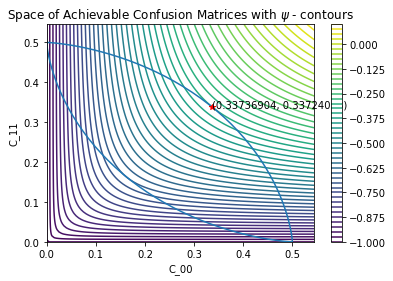

In [9]:
#Visualise space of achievable confusion matrices with \psi contours
feature_x = np.arange(0.0, 0.55, 0.005)
feature_y = np.arange(0.0, 0.55, 0.005)
  
# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)
fig, ax = plt.subplots(1, 1)
  
#Specify \psi
Z = -(1-2*(((y_0/X) + (y_1/Y))**(-1)))

plt.contour(X, Y, Z, 50)
plt.colorbar()
ax.set_title('Space of Achievable Confusion Matrices with $\psi$ - contours')
ax.set_xlabel('C_00')
ax.set_ylabel('C_11')

#Boundaries of achieveable space
plt.plot(ach_confs[:,0], ach_confs[:, -1]) 

#Provide optimum/ a guess for an optimum, and plot
optim = [0.33736904, 0.33724023]
plt.plot(optim[0], optim[1], 'r*')
plt.text(optim[0], optim[1], '({}, {})'.format(optim[0], optim[1]))

plt.show() 

In [10]:
#Generate validation dataset for true probability model
val_size = 1000000
#Space of achievable confusion matrices
X_val, y_val = get_val_data(val_size, mu, sigma, w, b)
Y_1 = np.array((1+np.exp(-(w*X_val + b)))**(-1)).flatten()
Y_0 = 1 - Y_1
etaa = np.transpose((Y_0, Y_1))

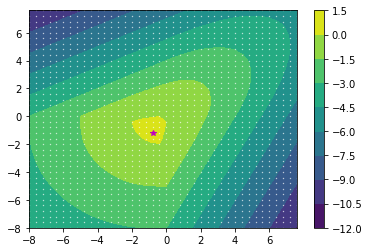

In [11]:
#Grid-search evaluations of f(\lambda), i.e., dual space
#Load data
funcs_ = np.loadtxt(filename, dtype = 'float')

#Write in conducive format
funcs = []
for ent, f in enumerate(funcs_): 
    kk = (np.array([f[0], f[1]]), f[2])
    funcs.append(kk)
    
#Visualize dual space, i.e., (\lambda, f(\lambda))
#White dots are evaluation points; magenta star is optimal f obtained in the grid-search
x = []
y = []
z = []
for i in funcs:
    x.append(i[0][0])
    y.append(i[0][1])
    z.append(i[1])
    
plt.tricontourf(x, y, z) #Super-level sets are convex
optim = funcs[np.argmax(z)][0]
plt.plot(optim[0], optim[1], 'm*') #grid search optimal 
plt.colorbar()
plt.scatter(x, y, s= 0.1, color = 'w')
plt.show()

max_grid = max(z)

In [12]:
############################# EXPERIMENTS START HERE ############################# 

In [13]:
#Provide as input the \rho values you'd like to evaluate over; b__ >= 1
def run_exps(rhos, b__):
    
    #Note: All variables with '_0' correspond to the case where we set \tau = 0
    
    
    #Lists to collect primal and dual optimums
    DUAL_OPTIMAS = []
    TAUS = []


    #Constants for the algorithm
    d = 4 #size of confusion matrix/ vector
    n = int(np.sqrt(d)) #effective input dimension/ #classes
    L = 4 #Lipschitz constant for \psi - computed using upper bound on gradient of \psi in domain 
    a = 2*L #sqrt(radius) of initial sphere
    T = 250 #Number of iterations; 250 seems more than sufficient to drown out compute error
    dec = 0.95 #P(X<= x*), if x<=x*, set \eta_hat to \eta +/- appropriate constant, else set \eta_hat = \eta
    cut = scipy.stats.norm.ppf(dec) #x*
    
    #True distributional params
    mu = 0.0 
    sigma = 1.0
    w = 1.0 
    b = 0.0
    
    #Predictions on validation data set
    Y_1 = np.array((1+np.exp(-(w*X_val + b)))**(-1)).flatten()
    Y_0 = 1 - Y_1
    etaa = np.transpose((Y_0, Y_1))
    
    #True confusion matrix corresponding to w, b, mu, sigma
    TC = get_conf_matrix(w, b, mu, sigma)
    TC = np.diag(TC)
    

    start = time.time()
    
    #Iterate over rhos
    for rho in rhos:

        end = time.time()
        print("NEW LOOP: ", end-start)

        checker = 0 #To check for termination in construction of new ellipsoids due to shallow cuts
        
        #Get tau, assuming rho' = 0
        tau = 4*L*rho
        TAUS.append(tau)
        print("rho: ", rho, 'tau: ', tau, 'b__: ', b__)
        
        #Get predictions calibrated to \rho
        #delta_ = rho/(2*dec)
        #Y_1 = np.array((1+np.exp(-(w*X_val + b)))**(-1) + 1.0*(X_val<=cut)*(delta_)).flatten()
        #Y_0 = 1 - Y_1
        #Y_pred_probs_val = np.transpose((Y_0, Y_1))
        
        #List to store \gamma_t values (= \tau/(quadratic(super-gradient, ellipsoid matrix))
        gammas = []
        
        #Initialize centre, matrix
        elambda = np.zeros(n).reshape(-1,1) #Initial centre
        A = np.identity(n)*(a**2) #Initial ellipsoid is the hyper-sphere w/ radius = a**2
        
        #SG stores the super-gradient at every iteration
        SG = np.zeros(n).reshape(-1,1) #Dummy inital value
                
        
        #Lists to store centres, matrices, gradients and f (dual) values through the iterations
        centres_ = []
        matrices_ = []
        grads_ = []
        Fs_ = []
        

        #Iterate
        for t in range(T):
            if(t%10 == 0):
                print(t)
            #Store centres/ matrices
            centres_.append(elambda)
            matrices_.append(A)

            #Sanity checks 
            #A, A_0 must be +ve definite 
            if(is_pos_def(A)!=1):
                print("issue")
            #Check that centres are contained in initial disc
            if(np.linalg.norm(elambda, 2) > a):
                print("centre outside")
                
            #C_t 
            #If volume reduction hasn't terminated, update C_t, else use previous C_t 
            if(checker == 0):
                true_C_t = LMO(elambda, etaa, y_val).flatten()
            
            #Xi_t
            
            #objective functions
            def objective(x): 
                return(1 - 2* (1.0/ ((y_0/x[0]) + (b__*y_1/x[1]))) - elambda.flatten()@x)


            #Set up for solving minimization to obtain Xi_t
            #define range for input
            r_min, r_max = 0, 1.0
            #define the starting point as a random sample from the domain
            pt = r_min + rand(2) * (r_max - r_min)
            bnds = ((0.0, 1.0), (0, 1.0)) # 0 <= Xi_t <= 1
            cons=({'type': 'ineq','fun': lambda x: -(x[0] + x[1] - 1)}) # sum(Xi_t) <= 1
            
            #If volume reduction hasn't terminated, update Xi_t, else use previous Xi_t
            if(checker == 0):
                result = minimize(objective, pt, method='SLSQP', constraints = cons, bounds=bnds)
                Xi_t = result['x']
            
            
            #Supergradients SG = C_t - Xi_t
            #Get approx. supergradients at \lambda
            true_SG = true_C_t - Xi_t 
            if (bernoulli.rvs(0.5, size=1)[0] == 0):
                SG = np.array([-true_SG[1], true_SG[0]])
            else: 
                SG = np.array([true_SG[1], -true_SG[0]])
            if(np.linalg.norm(elambda, 2) == 0):
                scale_ = tau/(2*L)
            else:
                cos_ = (elambda.flatten().dot(SG.flatten()))/(np.linalg.norm(SG, 2)*np.linalg.norm(elambda, 2))
                scale_ = tau/(2*L + np.linalg.norm(elambda)*cos_)
            SG = SG/np.linalg.norm(SG, 2)
            SG = scale_*SG 
            SG = SG + true_SG
            #SG = (1 - (tau/(4*L*np.linalg.norm(true_SG, 2))))*true_SG #SG is a \tau super-gradient of f_hat at \lambda
            #Strore super-gradient
            grads_.append(SG)
            
            #Evaluate and store f(\lambda)
            f = 1 - 2* (1.0/ ((y_0/Xi_t[0]) + (b__*y_1/Xi_t[1]))) + elambda.flatten().dot(true_SG.flatten())
            Fs_.append(f)
            
            #Evaluate and store gamma_t
            gammas.append(tau/np.sqrt(SG.dot(A.dot(SG))))
            
            #Get new ellipsoids
            if(checker == 0):
                elambda, A = JLE(A, elambda, SG, tau)
            else: 
                elambda, A = elambda, A

            if(np.linalg.det(A) == np.linalg.det(matrices_[-1])):
                checker = 1
        
        
        #Store dual optima
        f_max_ = max(Fs_)
        DUAL_OPTIMAS.append(f_max_)
        elambda_opt_ = centres_[np.argmax(Fs_)]
        print("dual_opt: ",  f_max_, "optimal \lambda: ", elambda_opt_.flatten())
        
        
        #Store/ plot volumes of ellipsoids 
        vols_ = []
        for cnt, cent in enumerate(centres_):
            vols_.append(np.pi*np.sqrt(np.linalg.det(matrices_[cnt])))
        # Plot of volumes
        plt.title('Volume of ellipsoids over iterations, input set to tau')
        plt.scatter(np.arange(len(vols_)),vols_)
        plt.plot(np.arange(len(vols_)), vols_)
        plt.show()
        
        #Does ellipsoid beat grid search? 
        print("Does the ellipsoid algorithm yield a more optimal point than the grid search (tau not zero)?: ", max_grid < f_max_)
        print("\n\n")
        
        #Store squared-l2 norms of super-gradients for case \tau = 4L*rho
        grad_norms = []
        for gr in grads_:
            grad_norms.append(np.linalg.norm(gr, 2)**2 )
        
        #Store minimum eigenvalues of matrices for case \tau = 4L*rho
        eigens = []
        for mt in matrices_:
            eigens.append(min(np.linalg.eigvals(mt)))
        
        #evolution of gamma_t for case \tau = 4L*rho
        print("t vs. gamma_t")
        plt.plot(np.arange(len(gammas)), gammas)
        plt.scatter(np.arange(len(gammas)), gammas)
        plt.show()
        
        #evolution of squared l2 norms of super-gradients for case \tau = 4L*rho
        print("t vs. SG_norm_squared_t")
        plt.plot(np.arange(len(grad_norms)), grad_norms)
        plt.scatter(np.arange(len(grad_norms)), grad_norms)
        plt.show()

        #evolution of min. eigenvalues of matrices for case \tau = 4L*rho
        print("t vs. min_eigenval_t")
        plt.plot(np.arange(len(eigens)), eigens)
        plt.scatter(np.arange(len(eigens)), eigens)
        plt.show()

        #Pre-processing to plot dual space
        x = []
        y = []
        z = []
        for i in funcs:
            x.append(i[0][0])
            y.append(i[0][1])
            z.append(i[1])

        col = 'r'

        for cnt, cent in enumerate(centres_):

            print("\gamma_t:", gammas[cnt])
            print("squared l2-norm of super-grad: ", grad_norms[cnt] )
            print("smallest eigenvalue of matrix: ", eigens[cnt])
            print("volume of ellipsoid: ", vols_[cnt])

            if(cnt > 0): 
                print("previous gamma_t: ", gammas[cnt-1])
                
                #Here we compute the ratio of volumes based on pg. 8 of the ellipsoid notability doc
                t_star = (1-(n*gammas[cnt-1]))/(n+1)
                num_TVR = ((1-t_star)**2)*(1-((gammas[cnt-1])*(gammas[cnt-1])))
                num_TVR = np.sqrt(num_TVR)
                den_TVR = ((1-t_star)**2) - ((gammas[cnt-1] + t_star)**2)
                den_TVR = np.sqrt(den_TVR)
                #TVR = theoretical volume ratio
                TVR = ((1-t_star)*((num_TVR)**(n-1)))/((den_TVR)**(n-1)) 
                if(gammas[cnt-1] > (1/(n))):
                    TVR = 1.0
                print("theoretical volume ratio: ", TVR)
                #As a sanity check, the empirical and theoretical volume ratio should match 
                print("volume ratio: ", vols_[cnt]/v_) #should = TVR

            v_ = vols_[cnt]
            
            #Visualize ellipsoid in dual space
            plt.tricontourf(x, y, z) #Super-level sets are convex
            plt.plot(elambda_opt_[0], elambda_opt_[1], 'b*')
            plt.xlim(-10,10)
            plt.ylim(-10,10)
            plt.colorbar()
            plot_ellipsoid(cent, matrices_[cnt], col, 'dashed')
            plt.title('Input set to tau')
            plt.show()
            
    
    #Return primal and dual optima obtained across iterations
    ERRORs = DUAL_OPTIMAS[0] - DUAL_OPTIMAS
    return(TAUS, DUAL_OPTIMAS, ERRORs)
    

In [14]:
"""
rhos = 0.1*np.arange(0.00, 0.105, 0.01)
rhos = list(rhos)
#Bs = (np.arange(-0.5, 10, 0.5) + 1)
Bs = (np.arange(-0.5, 10, 0.5) + 1)[:11] #tweaks the objective function 
DFs = []

#Run experiments
for b__ in Bs:
    TAUS, DUAL_OPTIMAS, ERRORs = run_exps(rhos, b__)
    DFs.append(pd.DataFrame(list(zip(TAUS , DUAL_OPTIMAS, ERRORs)), columns = ['tau', 'dual_opt', 'error']))
    
for df in DFs: 
    plt.plot(df['tau'], df['dual_opt'])
    plt.scatter(df['tau'], df['dual_opt'])
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('dual_optima')
    plt.show()
    
for df in DFs: 
    plt.plot(df['tau'], df['error'])
    plt.scatter(df['tau'], df['error'])
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')
    plt.show()
    

import matplotlib as mpl
#Darker colors correspond to larger value of b
weights = np.array([0,10])
norm_ = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm_, cmap=mpl.cm.Blues)
for i, df in enumerate(DFs):
    plt.plot(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.scatter(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')


names = []
for i in range(len(DFs)):
    names.append('sheet' + str(i+1))
    
writer = pd.ExcelWriter(r"/Users/dronakhurana/Desktop/ellipsoid_exps/upperbd/test1.xlsx")

_ = [A.to_excel(writer,sheet_name="{0}".format(names[i])) for i, A in enumerate(DFs)]
writer.save()
"""
"""
rhos = 0.1*np.arange(0.00, 0.105, 0.01)
rhos = list(rhos)
#Bs = (np.arange(-0.5, 10, 0.5) + 1)
Bs = (np.arange(-0.5, 10, 0.5) + 1)[11:14] #tweaks the objective function 
DFs_ = []

#Run experiments
for b__ in Bs:
    TAUS, DUAL_OPTIMAS, ERRORs = run_exps(rhos, b__)
    DFs_.append(pd.DataFrame(list(zip(TAUS , DUAL_OPTIMAS, ERRORs)), columns = ['tau', 'dual_opt', 'error']))
    
for df in DFs_: 
    plt.plot(df['tau'], df['dual_opt'])
    plt.scatter(df['tau'], df['dual_opt'])
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('dual_optima')
    plt.show()
    
for df in DFs_: 
    plt.plot(df['tau'], df['error'])
    plt.scatter(df['tau'], df['error'])
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')
    plt.show()
    

import matplotlib as mpl
#Darker colors correspond to larger value of b
weights = np.array([0,10])
norm_ = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm_, cmap=mpl.cm.Blues)
for i, df in enumerate(DFs_):
    plt.plot(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.scatter(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')


names = []
for i in range(len(DFs_)):
    names.append('sheet' + str(i+1))
    
writer = pd.ExcelWriter(r"/Users/dronakhurana/Desktop/ellipsoid_exps/upperbd/test3.xlsx")

_ = [A.to_excel(writer,sheet_name="{0}".format(names[i])) for i, A in enumerate(DFs_)]
writer.save()
"""
"""
rhos = 0.1*np.arange(0.00, 0.105, 0.01)
rhos = list(rhos)
#Bs = (np.arange(-0.5, 10, 0.5) + 1)
Bs = (np.arange(-0.5, 10, 0.5) + 1)[14:] #tweaks the objective function 
DFs__ = []

#Run experiments
for b__ in Bs:
    TAUS, DUAL_OPTIMAS, ERRORs = run_exps(rhos, b__)
    DFs__.append(pd.DataFrame(list(zip(TAUS , DUAL_OPTIMAS, ERRORs)), columns = ['tau', 'dual_opt', 'error']))
    
for df in DFs__: 
    plt.plot(df['tau'], df['dual_opt'])
    plt.scatter(df['tau'], df['dual_opt'])
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('dual_optima')
    plt.show()
    
for df in DFs__: 
    plt.plot(df['tau'], df['error'])
    plt.scatter(df['tau'], df['error'])
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')
    plt.show()

import matplotlib as mpl
#Darker colors correspond to larger value of b
weights = np.array([0,10])
norm_ = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm_, cmap=mpl.cm.Blues)
for i, df in enumerate(DFs__):
    plt.plot(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.scatter(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')
    
names = []
for i in range(len(DFs__)):
    names.append('sheet' + str(i+1))
    
writer = pd.ExcelWriter(r"/Users/dronakhurana/Desktop/ellipsoid_exps/upperbd/test2.xlsx")

_ = [A.to_excel(writer,sheet_name="{0}".format(names[i])) for i, A in enumerate(DFs__)]
writer.save()

"""


'\nrhos = 0.1*np.arange(0.00, 0.105, 0.01)\nrhos = list(rhos)\n#Bs = (np.arange(-0.5, 10, 0.5) + 1)\nBs = (np.arange(-0.5, 10, 0.5) + 1)[14:] #tweaks the objective function \nDFs__ = []\n\n#Run experiments\nfor b__ in Bs:\n    TAUS, DUAL_OPTIMAS, ERRORs = run_exps(rhos, b__)\n    DFs__.append(pd.DataFrame(list(zip(TAUS , DUAL_OPTIMAS, ERRORs)), columns = [\'tau\', \'dual_opt\', \'error\']))\n    \nfor df in DFs__: \n    plt.plot(df[\'tau\'], df[\'dual_opt\'])\n    plt.scatter(df[\'tau\'], df[\'dual_opt\'])\n    plt.title(\'Setting tau to 4L*rho\')\n    plt.xlabel(\'tau\')\n    plt.ylabel(\'dual_optima\')\n    plt.show()\n    \nfor df in DFs__: \n    plt.plot(df[\'tau\'], df[\'error\'])\n    plt.scatter(df[\'tau\'], df[\'error\'])\n    plt.title(\'Setting tau to 4L*rho\')\n    plt.xlabel(\'tau\')\n    plt.ylabel(\'error\')\n    plt.show()\n\nimport matplotlib as mpl\n#Darker colors correspond to larger value of b\nweights = np.array([0,10])\nnorm_ = mpl.colors.Normalize(vmin=min(weights

In [15]:
#Load all the statistics for the experiments, i.e., data frames of form 'tau | dual_optima | error' 
#for each of the 23 objectives
xls1 = pd.ExcelFile(file1)
xls2 = pd.ExcelFile(file2)
xls3 = pd.ExcelFile(file3)


stats = []
for sheet in xls1.sheet_names:
    stats.append(pd.read_excel(file1, sheet_name = sheet))
for sheet in xls3.sheet_names:
    stats.append(pd.read_excel(file3, sheet_name = sheet))
for sheet in xls2.sheet_names:
    stats.append(pd.read_excel(file2, sheet_name = sheet))

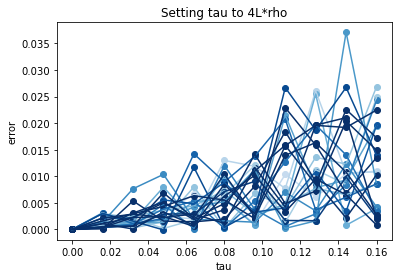

In [16]:
#Visualize tau vs. error for all objectives

import matplotlib as mpl
#Darker colors correspond to larger value of b__
weights = np.array([0,20])
norm_ = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm_, cmap=mpl.cm.Blues)
for i, df in enumerate(stats):
    plt.plot(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.scatter(df['tau'], df['error'], color=cmap.to_rgba(i+5))
    plt.title('Setting tau to 4L*rho')
    plt.xlabel('tau')
    plt.ylabel('error')



line of best fit; slope and intercept respectively:  0.20335763798306786 2.5950690839889913e-05


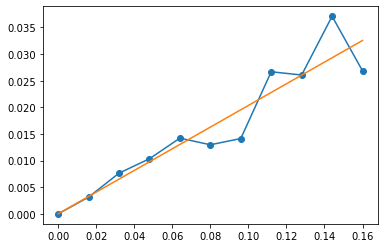

In [18]:
#Visualize the upper envelope for tau vs error (blue) and get line of best fit (orange)

mega = pd.concat(stats)
mega = mega[['tau', 'dual_opt', 'error']]
mega.head(5)

upper_env = []
taus = mega.tau.unique()
for t in taus: 
    upper_env.append((max(mega[mega['tau'] == t]['error'])))
    
plt.plot(taus, upper_env)
plt.scatter(taus, upper_env)
m, b = np.polyfit(taus, upper_env, 1)
print("line of best fit; slope and intercept respectively: ", m,b)
#plt.plot(taus, upper_env, 'o')
plt.plot(taus, m*taus + b)